# Assignment 4

By: Jordan Ponn (996765781) <br>
Course: MIE1513

## Helper Functions

In [1]:
#Download required ntlk packages and lib
import nltk
# For Sentiment Analysis
nltk.download("vader_lexicon")
nltk.download("stopwords")

# For Noun Phrases
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jordan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jordan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jordan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jordan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Import needed libraries
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
import numpy as np
import math

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords

# For Noun phrases
from nltk.tag import PerceptronTagger
from nltk.data import find

from collections import Counter
import re

import sklearn
import sklearn.metrics as metrics

C:\Anaconda\envs\py35\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Get Word Count and Frequency

In [3]:
# Count word frequency in a list of documents, excluding terms in a stopword list
def countWords(corpus, onlyNp = False):
    counter = Counter()
    # Open the files and count the word frequency in each file in a loop and update the counter after finished processing a file
    for doc in corpus:
        # Get noun phrase token list
        tokenList = getTokens(doc, onlyNp)
        counter.update([word for word in tokenList])
    return counter

# Get frequency of topK words in individual reviews
def calcWordFreq(corpus, topK, onlyNp = False):
    freqReview = []
    for doc in corpus:
        # Get noun phrase token list
        tokenList = getTokens(doc, onlyNp)
        tempCounter = Counter([word for word in tokenList])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topK]
        freqReview.append(topkinReview)
    return freqReview

### Prepare VADER Scores

In [4]:
# Assign Vader score to individual review using Vader compound score
def calcVaderScore(corpus, showProgress=False):
    pdlist = []
    for rownum, doc in enumerate(corpus):
        ss = sid.polarity_scores(doc)
        pdlist.append([doc]+[ss['compound']])
        if (rownum % 100 == 1 and showProgress):
                print("processed %d reviews" % (rownum+1))
    return pdlist

### Prepare Dataframe for Analysis

In [5]:
def prepareFinalDataframe(hotelDF, topK):
    corpus = hotelDf['reviewColumn'].as_matrix()
    
    # Prepare VADER dataframe
    vaderDf = pandas.DataFrame(calcVaderScore(corpus))
    vaderDf.columns = ['reviewCol','vader']

    # Prepare frequency review dataframe   
    freqReviewDf = pandas.DataFrame(calcWordFreq(corpus, topK))
    freqReviewDf.columns = [word for (word, wordCount) in topK]
    
    # Return merge of all dataframes
    return hotelDf[['hotelName','ratingScore','groundTruth']].join(vaderDf.join(freqReviewDf))

### Mutual Information Analysis

In [6]:
# Calcualte MI scores
def miCalc(df, topK, scoreMetric):
    gtScore = []
    
    # Assign threshold value based on score metric used
    threshold = 0
    if scoreMetric == 'ratingScore':
        threshold = 3
    elif scoreMetric == 'vader':
        threshold = vaderPosThreshold
    
    # Convet score metric to binary values
    for i in range(len(df)):
        if df[scoreMetric].as_matrix()[i]>threshold:
            gtScore.append(1)
        else:
            gtScore.append(0)            

    # Perform MI Analysis for each word
    miScore = []
    for word, wordCount in topK:
        miScore.append([word]+[metrics.mutual_info_score(gtScore, df[word].as_matrix())])
    
    return miScore

In [7]:
# Helper funciton to help sort by score in a word,score tuple
def getSortKey(item):
    return item[1]

def miAnalysis(df, topK):
    groundTruth = pandas.DataFrame(sorted(miCalc(df, topK, 'ratingScore'), key=getSortKey, reverse=True)[:50], 
                                   columns=["Word (Ground Truth)", "MI Score"])
    vader = pandas.DataFrame(sorted(miCalc(df, topK, 'vader'), key=getSortKey, reverse=True)[:50],
                             columns=["Word (VADER)", "MI Score"])
        
    # Add gap column in dataframe for formatting
    groundTruth[" "] = ' '
    
    # Concatinate and return resulting dataframe
    return pandas.concat([groundTruth, vader], axis=1)    

### Pointwise Mutual Information Analysis

In [8]:
# Calcualte a PMI score for word x using a scoring metric
def pmiCal(df, x, scoreMethod):
    try:
        pmilist=[]
        for i in ['positive','negative']:
            for j in [0,1]:
                # Initialize probability values
                px = 0
                py = 0
                pxy = 0
                
                if scoreMethod =='ratingScore':
                    # Compute binary representation using ground truth values
                    px = sum(df['groundTruth']==i)/len(df)
                    py = sum(df[x]==j)/len(df)
                    pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
                elif scoreMethod =='vader':
                    # Compute binary representation using VADER scores and thersholds for positive/negative sentiment
                    if i =='positive':
                        px = sum(df['vader']>vaderPosThreshold)/len(df)
                        pxy = len(df[(df['vader']>vaderPosThreshold) & (df[x]==j)])/len(df)
                    elif i =='negative':
                        px = sum(df['vader']<vaderNegThreshold)/len(df)
                        pxy = len(df[(df['vader']<vaderNegThreshold) & (df[x]==j)])/len(df)
                        
                    py = sum(df[x]==j)/len(df)
                
                if pxy==0:#Log 0 cannot happen
                    pmi = math.log10((pxy+0.0001)/(px*py))
                else:
                    pmi = math.log10(pxy/(px*py))
                pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
        
        # Format and return results
        pmidf = pandas.DataFrame(pmilist)
        pmidf.columns = ['x','y','px','py','pxy','pmi']
        return pmidf
    # Print error if term is not found
    except KeyError:
        print("Error: Term not found")

### Create Stopword List

In [9]:
# Create wordlist of all all hotel names
def getWordsInHotelName():
    hotelNames = hotelDf['hotelName'].unique()
    wordList = []
    for name in hotelNames:
        wordList.extend([word.lower() for word in re.findall(r'\w+', name)])
    return set(wordList)

def getStopwords():
    stopwordList = set(stopwords.words('english'))
    
    #Add Possible Stop Words for Hotel Reviews
    stopwordList.add('hotel')
    stopwordList.add('room')
    stopwordList.add('rooms')
    stopwordList.add('stay')
    stopwordList.add('staff')

    # Add Hotel Names as stop words
    for name in hotelDf['hotelName'].unique():
        stopwordList.add(name.lower())
        
    for word in getWordsInHotelName():
        stopwordList.add(word)

    # Remove any redundant words
    return set(stopwordList)

### Noun Phrase Creation

Setup tagger (from http://stackoverflow.com/a/35964709)

In [10]:
PICKLE = "averaged_perceptron_tagger.pickle"
AP_MODEL_LOC = 'file:'+str(find('taggers/averaged_perceptron_tagger/'+PICKLE))
tagger = PerceptronTagger(load=False)
tagger.load(AP_MODEL_LOC)
pos_tag = tagger.tag

lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

Used https://gist.github.com/alexbowe/879414 as reference for Noun Phrase extraction.  lambda funciton was modified to use label() function as node() is now depreciated.

In [11]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
        yield subtree.leaves()

def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 < len(word) and word.lower() not in stopwords)
    return accepted        

def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem_word(word)
    word = lemmatizer.lemmatize(word)
    return word

def get_terms(tree):
    for leaf in leaves(tree):
        term = [ w.lower() for w,t in leaf if acceptable_word(w) ]
        yield term
        
def getTokens(text, onlyNp):
    words = re.findall(r'\w+', text)
    
    # Tag words and build noun phrases
    taggedToks = pos_tag(words)
    
    # Build phrase tree    
    chunker = nltk.RegexpParser(grammar)
    tree= chunker.parse(taggedToks)
    
    # Travese tree and get noun phrases
    npList = [word for word in get_terms(tree)]
    
    tokenList = []
    # Add Noun Phrases to token list
    for phrase in npList:
        token =  ''
        for word in phrase:
            token += word + " "
        if len(token) > 0:
            tokenList.append(token.rstrip())
    
    # Add remaining tokens that are not noun phrases
    if onlyNp is False:
        # Make copy of np tokens to ensure duplicates are not added to final token list
        npTokenList = list(tokenList)
        
        # Add words to token list that are not nouns, and that are not already counted in noun phrases
        for word, tag in taggedToks:
            if tag[:2] != 'NN' and word.lower() not in stopwords and word.lower() not in npTokenList and len(word) > 2:
                tokenList.append(word.lower())
    
    return tokenList

## Assignment Questions

In [12]:
# Import Data - Using all hotels from Kelowna, B.C., Canada
hotelDf = pandas.read_csv('resources/data/kelowna.csv')
hotelDf.columns=['idNum','filePath','hotelName','reviewColumn','ratingScore','groundTruth']

In [13]:
# Initialization and constants
sid = SentimentIntensityAnalyzer()
stopwords = getStopwords()
k = 500
vaderPosThreshold = 0.25
vaderNegThreshold = -0.25

In [14]:
# Get top K words from reviews
topK = countWords(hotelDf['reviewColumn'].as_matrix()).most_common(k)

# Create final dataframe
finalDF = prepareFinalDataframe(hotelDf, topK)
finalDF

,hotelName,ratingScore,groundTruth,reviewCol,vader,great,would,good,clean,stayed,...,heard,outstanding,air,entire,terrible,ago,waiting,finally,overnight,larger
0,Hotel Zed Kelowna,5,positive,What a great place to stay!!! Right across fro...,0.9466,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hotel Zed Kelowna,5,positive,We found this new retro themed motel in downto...,0.8074,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hotel Zed Kelowna,5,positive,I think we were one of the very first people t...,0.9858,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Hotel Zed Kelowna,5,positive,I stayed at the hotel with my wife and two chi...,0.9041,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Hotel Zed Kelowna,3,negative,First the good. The staff are very good and at...,0.8555,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Hotel Zed Kelowna,5,positive,booked this through expedia. room for a few ni...,0.9928,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6,Hotel Zed Kelowna,5,positive,We stayed for one night in order to fit in som...,0.9805,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
7,Hotel Zed Kelowna,5,positive,Mandy Farmer throws some serious Accent Inn at...,0.7603,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Hotel Zed Kelowna,4,positive,My husband and I stayed at this hotel when we ...,0.9917,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9,Hotel Zed Kelowna,4,positive,The hotel was clean and offered some unique ex...,0.9402,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


### Q1.) Sentiment Analysis and Aggregation

In [15]:
# Calculate average rating and vader score per hotel
def calcAvgScore(df):
    hotelRating = []
    for hotel in df['hotelName'].unique():
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf['ratingScore'].mean(), itemDf['ratingScore'].var(), 
                            itemDf['vader'].mean(), itemDf['vader'].var()])
    
    # Format and return results
    hotelRatingDf = pandas.DataFrame(hotelRating)
    hotelRatingDf.columns=['hotelName','avgRatingScore', 'varRatingScore','avgVaderScore', 'varVaderScore']
    return hotelRatingDf

In [16]:
# Create rating per hotel
itemDF = calcAvgScore(finalDF)

In [17]:
# Ground Truth Rating Top 5
itemDF.sort_values('avgRatingScore',ascending=0).head(5)

,hotelName,avgRatingScore,varRatingScore,avgVaderScore,varVaderScore
26,Bellasera,4.916667,0.083333,0.940142,0.003491
23,Four Points by Sheraton Kelowna Airport,4.546547,0.483520,0.897856,0.045342
2,The Royal Private Residence Club,4.527273,0.661279,0.916413,0.039646
27,The Charles M Suites,4.500000,0.500000,0.903300,0.006227
5,Best Western Plus Kelowna Hotel &amp; Suites,4.438824,0.585770,0.882446,0.070511


In [18]:
# Ground Truth Rating Bottom 5
itemDF.sort_values('avgRatingScore',ascending=1).head(5)

,hotelName,avgRatingScore,varRatingScore,avgVaderScore,varVaderScore
15,Town and Country Motel,2.421053,2.682788,0.208597,0.655113
29,Canadas Best Value Inn,2.681818,2.128964,0.398743,0.525934
13,Econo Lodge,2.694915,1.905319,0.432056,0.517950
17,Lake Okanagan Resort,2.731638,1.788968,0.495263,0.476715
31,Oasis Inn,2.896104,1.725906,0.428168,0.529135


In [19]:
# VADER Score Rating Top 5
itemDF.sort_values('avgVaderScore',ascending=0).head(5)

,hotelName,avgRatingScore,varRatingScore,avgVaderScore,varVaderScore
26,Bellasera,4.916667,0.083333,0.940142,0.003491
2,The Royal Private Residence Club,4.527273,0.661279,0.916413,0.039646
27,The Charles M Suites,4.500000,0.500000,0.903300,0.006227
23,Four Points by Sheraton Kelowna Airport,4.546547,0.483520,0.897856,0.045342
5,Best Western Plus Kelowna Hotel &amp; Suites,4.438824,0.585770,0.882446,0.070511


In [20]:
# VADER Score Rating Bottom 5
itemDF.sort_values('avgVaderScore',ascending=1).head(5)

,hotelName,avgRatingScore,varRatingScore,avgVaderScore,varVaderScore
15,Town and Country Motel,2.421053,2.682788,0.208597,0.655113
30,Howard Johnson Kelowna,3.107784,2.012409,0.359445,0.484538
29,Canadas Best Value Inn,2.681818,2.128964,0.398743,0.525934
31,Oasis Inn,2.896104,1.725906,0.428168,0.529135
13,Econo Lodge,2.694915,1.905319,0.432056,0.517950


Ground truth rating and VADER rating correlate with eachother fairly well.  Top 5 had the same 5 hotels in both metrics, with the 2nd place ground truth item in 4th on the VADER rank.  Bottom 5 had 4 similar hotels in both metrics, but the order of items varied except for the last place hotel.

### Q2.) Frequency Analysis

In [21]:
# Formatting helper function to horizontaly concatinate two lists, and add a gap between them
def compareWordLists(wordList1, wordList2):
    leftDf = pandas.DataFrame(wordList1, columns=["Word (Ground Truth)", "Word Count"])
    rightDf = pandas.DataFrame(wordList2, columns=["Word (VADER)", "Word Count"])
    
    # Add gap column in dataframe for formatting
    leftDf[" "] = ' '
    
    # Concatinate and return resulting dataframe
    return pandas.concat([leftDf, rightDf], axis=1)

#### All Hotels

##### Positive Reviews

In [22]:
# Compare top 50 words for positive reviews, and VADER scores above threshold
compareWordLists(countWords(finalDF.loc[finalDF['groundTruth']=='positive']['reviewCol'].as_matrix()).most_common(50),
                 countWords(finalDF.loc[finalDF['vader']>vaderPosThreshold]['reviewCol'].as_matrix()).most_common(50))

,Word (Ground Truth),Word Count,,Word (VADER),Word Count
0,great,3838,,great,4341
1,clean,3128,,good,3821
2,good,3033,,clean,3793
3,stayed,2604,,would,3613
4,would,2603,,stayed,3159
5,friendly,2438,,nice,2998
6,nice,2423,,one,2928
7,one,2206,,friendly,2848
8,well,2114,,well,2493
9,comfortable,2087,,comfortable,2352


##### Negative Reviews

In [23]:
# Compare top 50 words for negative reviews, and VADER scores below threshold
compareWordLists(countWords(finalDF.loc[finalDF['groundTruth']=='negative']['reviewCol'].as_matrix()).most_common(50),
                 countWords(finalDF.loc[finalDF['vader']<vaderNegThreshold]['reviewCol'].as_matrix()).most_common(50))

,Word (Ground Truth),Word Count,,Word (VADER),Word Count
0,would,1574,,would,454
1,one,1113,,one,318
2,good,1035,,stayed,252
3,stayed,885,,get,251
4,clean,872,,night,243
5,get,856,,back,220
6,night,845,,told,212
7,could,743,,place,200
8,nice,736,,could,191
9,like,713,,even,177


Words between ground truth and VADER scores are fairly similar.  Surprisingly, some of the frequent words in the negative review list were also relativly positive.  This may be because the negative review terms were actually negated (i.e. 'Not good' instead of 'good'), or the negative reviews mentioned both positive and negative aspects about the hotel.  Single word tokens appear to dominate over multi-word noun phrases.

#### Top and Bottom Reviewed Hotel

In [24]:
# Get name of top and bottom hotels
topHotelName = itemDF.sort_values('avgRatingScore',ascending=0).iloc[0][0]
bottomHotelName = itemDF.sort_values('avgRatingScore',ascending=1).iloc[0][0]

##### Top Hotel

###### Positive

In [25]:
print("Top hotel: {0}".format(topHotelName))

# Compare top 50 words for postive reviews, and VADER scores above threshold for top hotel
compareWordLists(countWords(finalDF[(finalDF['hotelName']==topHotelName) & 
                                    (finalDF['groundTruth']=='positive')]['reviewCol'].as_matrix()).most_common(50),
                 countWords(finalDF[(finalDF['hotelName']==topHotelName) & 
                                    (finalDF['vader']>vaderPosThreshold)]['reviewCol'].as_matrix()).most_common(50))

Top hotel: Bellasera


,Word (Ground Truth),Word Count,,Word (VADER),Word Count
0,stayed,8,,stayed,8
1,would,7,,would,7
2,also,6,,also,6
3,beautiful,5,,beautiful,5
4,two,5,,two,5
5,comfortable,5,,comfortable,5
6,great,5,,great,5
7,bella sera,5,,bella sera,5
8,right,5,,right,5
9,location,4,,location,4


###### Negative

In [26]:
# Compare top 50 words for negative reviews, and VADER scores below threshold for top hotel
compareWordLists(countWords(finalDF[(finalDF['hotelName']==topHotelName) & 
                                    (finalDF['groundTruth']=='negative')]['reviewCol'].as_matrix()).most_common(50),
                 countWords(finalDF[(finalDF['hotelName']==topHotelName) & 
                                    (finalDF['vader']<vaderNegThreshold)]['reviewCol'].as_matrix()).most_common(50))

,Word (Ground Truth),Word Count,,Word (VADER),Word Count


Ground truth and VADER scores were fairly similar for both lists for the top hotel for positive reviews.  There were no negative reviews for this hotel, so word lists could not be created.  The lists are likely very similar as there were few reviews to begin with.

##### Bottom Hotel

###### Positive

In [27]:
print("Bottom hotel: {0}".format(bottomHotelName))

# Compare top 50 words for postive reviews, and VADER scores above threshold for worst hotel
compareWordLists(countWords(finalDF[(finalDF['hotelName']==bottomHotelName) & 
                                    (finalDF['groundTruth']=='positive')]['reviewCol'].as_matrix()).most_common(50),
                 countWords(finalDF[(finalDF['hotelName']==bottomHotelName) & 
                                    (finalDF['vader']>vaderPosThreshold)]['reviewCol'].as_matrix()).most_common(50))

Bottom hotel: Town and Country Motel


,Word (Ground Truth),Word Count,,Word (VADER),Word Count
0,friendly,11,,friendly,13
1,good,9,,clean,11
2,nice,9,,nice,11
3,stayed,7,,good,10
4,clean,6,,stayed,9
5,would,5,,like,8
6,helpful,4,,would,7
7,time,4,,got,7
8,front desk,3,,place,6
9,may,3,,get,6


###### Negative

In [28]:
# Compare top 50 words for negative reviews, and VADER scores below threshold for worst hotel
compareWordLists(countWords(finalDF[(finalDF['hotelName']==bottomHotelName) & 
                                    (finalDF['groundTruth']=='negative')]['reviewCol'].as_matrix()).most_common(50),
                 countWords(finalDF[(finalDF['hotelName']==bottomHotelName) & 
                                    (finalDF['vader']<vaderNegThreshold)]['reviewCol'].as_matrix()).most_common(50))

,Word (Ground Truth),Word Count,,Word (VADER),Word Count
0,back,15,,back,10
1,like,14,,told,10
2,place,14,,place,9
3,even,13,,would,9
4,got,12,,even,8
5,told,12,,got,7
6,would,11,,bad,7
7,night,10,,night,7
8,left,9,,left,6
9,bad,9,,two,6


Ground truth and VADER scores gave similar word lists for both positive and negative reviews for the worst hotel.

### Q3.) Mutual Information

#### All Hotels

In [29]:
# Get top 50 words based on MI score using ground truth and VADER scores for all hotel
miAnalysis(finalDF, topK)

,Word (Ground Truth),MI Score,,Word (VADER),MI Score
0,told,0.024209,,great,0.017913
1,dirty,0.021862,,dirty,0.013521
2,old,0.019914,,friendly,0.012972
3,great,0.017308,,comfortable,0.010998
4,said,0.015098,,told,0.010099
5,poor,0.014212,,clean,0.009847
6,excellent,0.012429,,helpful,0.009254
7,comfortable,0.012368,,excellent,0.008905
8,night,0.011842,,poor,0.008756
9,terrible,0.011546,,never,0.007995


The VADER scored words ranks descriptor words more highly than the ground truth list.  This would suggest that VADER is identifying these phrases as more useful when identifying if a review is positive or negative.

#### Top and Bottom Hotels

In [30]:
# Recreating frequency matrixies as using main top k word list gives very weak MI scores
# Get top K words from reviews for top hotel, and create frequency matrix
topKTopHotel = countWords(hotelDf.loc[hotelDf['hotelName']==topHotelName]['reviewColumn'].as_matrix()).most_common(k)
topHotelDf = prepareFinalDataframe(hotelDf.loc[hotelDf['hotelName']==topHotelName], topKTopHotel)

# Get top K words from reviews for bottom hotel, and create frequency matrix
topKBottomHotel = countWords(hotelDf.loc[hotelDf['hotelName']==bottomHotelName]['reviewColumn'].as_matrix()).most_common(k)
bottomHotelDf = prepareFinalDataframe(hotelDf.loc[hotelDf['hotelName']==bottomHotelName], topKBottomHotel)

##### Top Hotel

In [31]:
# Get top 50 words based on MI score using ground truth and VADER scores for top hotel
miAnalysis(topHotelDf, topKTopHotel)

,Word (Ground Truth),MI Score,,Word (VADER),MI Score
0,great,0.017308,,great,0.017913
1,said,0.015098,,friendly,0.012972
2,excellent,0.012429,,comfortable,0.010998
3,comfortable,0.012368,,clean,0.009847
4,night,0.011842,,helpful,0.009254
5,left,0.011262,,excellent,0.008905
6,get,0.010614,,left,0.006803
7,enjoyed,0.008785,,enjoyed,0.006267
8,friendly,0.008487,,said,0.006089
9,could,0.008342,,well,0.005195


##### Bottom Hotel

In [32]:
# Get top 50 words based on MI score using ground truth and VADER scores for worst hotel
miAnalysis(bottomHotelDf, topKBottomHotel)

,Word (Ground Truth),MI Score,,Word (VADER),MI Score
0,told,0.024209,,great,0.017913
1,dirty,0.021862,,dirty,0.013521
2,old,0.019914,,friendly,0.012972
3,great,0.017308,,comfortable,0.010998
4,said,0.015098,,told,0.010099
5,comfortable,0.012368,,clean,0.009847
6,night,0.011842,,helpful,0.009254
7,terrible,0.011546,,rude,0.008537
8,never,0.011422,,never,0.007995
9,rude,0.011335,,terrible,0.007769


Similar to the lists encompasing all hotels, the VADER scoring methods tends to rank descriptor words more highly than the ground truth list. 

### Q4.) Pointwise Mutual Information

In [33]:
# Perform PMI calculation for each word in top k
def pmiAnalysis(df, topK, scoreMethod):
    scoreList = []
    for word, wordCount in topK:
        # Calcualte PMI scores for each word
        scoreList.append([word] + pmiCal(df, word, scoreMethod)['pmi'].tolist())
    
    # Format results for to display in pandas dataframe
    headers = ['pmiPos0', 'pmiPos1', 'pmiNeg0', 'pmiNeg1']
    resultDfs = []
    for i in range(0,4):
        # Keep top 50 words based on PMI score
        tempDf = pandas.DataFrame(sorted([[row[0], row[i+1]] for row in scoreList], key=getSortKey, reverse=True)[:50], 
                         columns=["Word", headers[i]])
        # Add spacing for formatting
        if i < 3:
            tempDf[" "] = " "
        resultDfs.append(tempDf)
        
    return pandas.concat(resultDfs, axis=1)

#### All Hotels

##### Ground Truth

In [34]:
# Get top 50 words based on PMI score using ground truth for all hotels
pmiAnalysis(finalDF, topK, 'ratingScore')

,Word,pmiPos0,,Word,pmiPos1,,Word,pmiNeg0,,Word,pmiNeg1
0,would,0.019839,,highly,0.111308,,great,0.090239,,dirty,0.524830
1,night,0.018381,,loved,0.098350,,comfortable,0.058861,,terrible,0.515461
2,get,0.017207,,awesome,0.097071,,friendly,0.055818,,poor,0.491214
3,old,0.014507,,delicious,0.096919,,clean,0.045611,,carpet,0.478876
4,could,0.014085,,perfect,0.096817,,excellent,0.037357,,told,0.439023
5,told,0.014014,,enjoyed,0.092092,,helpful,0.035310,,finally,0.428758
6,like,0.013598,,amazing,0.092073,,well,0.029413,,cleaned,0.420873
7,one,0.013591,,outstanding,0.091686,,definitely,0.025463,,paid,0.395517
8,got,0.011119,,fantastic,0.090476,,enjoyed,0.025439,,dated,0.381178
9,said,0.010844,,excellent,0.089463,,spacious,0.022124,,said,0.380264


##### VADER Score

In [35]:
# Get top 50 words based on PMI score using VADER scores for all hotels
pmiAnalysis(finalDF, topK, 'vader')

,Word,pmiPos0,,Word,pmiPos1,,Word,pmiNeg0,,Word,pmiNeg1
0,told,0.005801,,efficient,0.045600,,great,0.141872,,terrible,0.757467
1,never,0.005687,,delicious,0.045242,,clean,0.120220,,dirty,0.756861
2,dirty,0.005127,,outstanding,0.044467,,friendly,0.103796,,poor,0.718528
3,night,0.004851,,wonderful,0.043327,,comfortable,0.087740,,manager,0.592028
4,get,0.004844,,plenty,0.043296,,good,0.077614,,told,0.585562
5,old,0.004682,,loved,0.043087,,nice,0.065695,,cleaned,0.560851
6,left,0.004502,,enjoyed,0.042794,,helpful,0.063823,,reservation,0.547508
7,bad,0.004318,,courteous,0.042219,,well,0.059957,,disappointed,0.517020
8,said,0.004306,,excellent,0.041914,,excellent,0.050182,,called,0.514206
9,place,0.004036,,awesome,0.041830,,quiet,0.035262,,left,0.513591


The ground truth scores tended to have stronger correlations with positive reviews (pmiPos1), while the VADER scores had stronger correlations with negative reviews (pmiNeg1). This may be because positive reviewers are commenting on different aspects which was a highlight for them, while negative reviewers are all complaining about the same topics.  Several noun phrases appear in the positive word list (pmiPos1).

#### Top Hotel

##### Ground Truth

In [36]:
# Get top 50 words based on PMI score using ground truth for top hotel
pmiAnalysis(topHotelDf, topKTopHotel, 'ratingScore')

,Word,pmiPos0,,Word,pmiPos1,,Word,pmiNeg0,,Word,pmiNeg1
0,would,0.019839,,bella sera,0.128934,,great,0.090239,,impresses,0.556244
1,night,0.018381,,awsome,0.128934,,comfortable,0.058861,,months last september october,0.556244
2,get,0.017207,,quail,0.128934,,friendly,0.055818,,unforgettable breakfast,0.556244
3,could,0.014085,,quail golf course,0.128934,,clean,0.045611,,upper corners,0.556244
4,like,0.013598,,impresses,0.128934,,excellent,0.037357,,local walmart,0.556244
5,one,0.013591,,spatious,0.128934,,helpful,0.035310,,city noise,0.556244
6,said,0.010844,,months last september october,0.128934,,well,0.029413,,reception lovely pool area great bar,0.556244
7,place,0.010292,,unforgettable breakfast,0.128934,,definitely,0.025463,,short duration,0.556244
8,front desk,0.009534,,upper corners,0.128934,,enjoyed,0.025439,,stainless,0.556244
9,booked,0.009438,,ensuite bathrooms,0.128934,,spacious,0.022124,,groupon,0.556244


##### VADER Score

In [37]:
# Get top 50 words based on PMI score using VADER scores for top hotel
pmiAnalysis(topHotelDf, topKTopHotel, 'vader')

,Word,pmiPos0,,Word,pmiPos1,,Word,pmiNeg0,,Word,pmiNeg1
0,night,0.004851,,awsome,0.047452,,great,0.141872,,impresses,1.095584
1,get,0.004844,,development,0.047452,,clean,0.120220,,months last september october,1.095584
2,left,0.004502,,bear,0.047452,,friendly,0.103796,,unforgettable breakfast,1.095584
3,said,0.004306,,quail,0.047452,,comfortable,0.087740,,upper corners,1.095584
4,place,0.004036,,several years,0.047452,,good,0.077614,,local walmart,1.095584
5,would,0.004026,,planes,0.047452,,nice,0.065695,,city noise,1.095584
6,booked,0.003869,,uncle,0.047452,,helpful,0.063823,,reception lovely pool area great bar,1.095584
7,could,0.003597,,full range,0.047452,,well,0.059957,,short duration,1.095584
8,front desk,0.003141,,granite,0.047452,,excellent,0.050182,,stainless,1.095584
9,first,0.002895,,unforgettable,0.047452,,quiet,0.035262,,groupon,1.095584


#### Bottom Hotel

##### Ground Truth

In [38]:
# Get top 50 words based on PMI score using ground truth for worst hotel
pmiAnalysis(bottomHotelDf, topKBottomHotel, 'ratingScore')

,Word,pmiPos0,,Word,pmiPos1,,Word,pmiNeg0,,Word,pmiNeg1
0,would,0.019839,,busy summer schedule,0.128934,,great,0.090239,,hadnt,0.59029
1,night,0.018381,,christmas shopping,0.128934,,comfortable,0.058861,,low budget,0.59029
2,get,0.017207,,warm pool,0.128934,,friendly,0.055818,,phone work,0.59029
3,old,0.014507,,new managers,0.128934,,clean,0.045611,,unhappy,0.59029
4,could,0.014085,,beds easy access,0.128934,,helpful,0.035310,,winged,0.59029
5,told,0.014014,,nice place pool,0.128934,,well,0.029413,,husband asume,0.59029
6,like,0.013598,,noir,0.128934,,definitely,0.025463,,hostile,0.59029
7,one,0.013591,,last review,0.128934,,spacious,0.022124,,wrongfully,0.59029
8,got,0.011119,,main highway tip corner,0.128934,,quiet,0.022089,,carpet wasnt,0.59029
9,said,0.010844,,buffy,0.128934,,always,0.020845,,full night thanks,0.59029


##### VADER Score

In [39]:
# Get top 50 words based on PMI score using VADER score for worst hotel
pmiAnalysis(bottomHotelDf, topKBottomHotel, 'vader')

,Word,pmiPos0,,Word,pmiPos1,,Word,pmiNeg0,,Word,pmiNeg1
0,told,0.005801,,finger,0.047452,,great,0.141872,,phone work,1.129630
1,never,0.005687,,new management,0.047452,,clean,0.120220,,carpet wasnt,1.129630
2,dirty,0.005127,,air condition,0.047452,,friendly,0.103796,,unhappy tired customers,1.129630
3,night,0.004851,,numerous places,0.047452,,comfortable,0.087740,,kitchen dishes,1.129630
4,get,0.004844,,resent,0.047452,,good,0.077614,,stench windows,1.129630
5,old,0.004682,,ratings,0.047452,,nice,0.065695,,flames,1.129630
6,left,0.004502,,spilled,0.047452,,helpful,0.063823,,burns,1.129630
7,bad,0.004318,,aircondition,0.047452,,well,0.059957,,intoroom108,1.129630
8,said,0.004306,,useful,0.047452,,quiet,0.035262,,crumples,1.129630
9,place,0.004036,,spacious see,0.047452,,definitely,0.030290,,following problems,1.129630


Similar to when the analysis was run across all hotels, the ground truth scores tended to have stronger correlations with positive reviews (pmiPos1), while the VADER scores had stronger correlations with negative reviews (pmiNeg1).  Noun phrases appear a lot more frequently in all cases.  This is likely due reviews references specific items that belong only to these hotels, which are contributed to their experience.

### Q5.) General Plots

#### Histogram

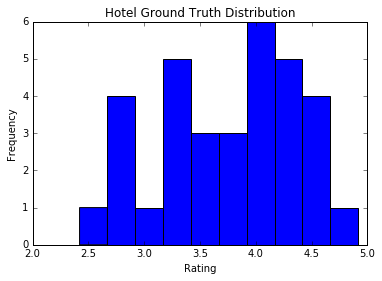

In [40]:
# Plot ground truth ratings on histogram
plt.hist(itemDF['avgRatingScore'].as_matrix(), bins =10)
plt.title("Hotel Ground Truth Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
fig = plt.gcf()

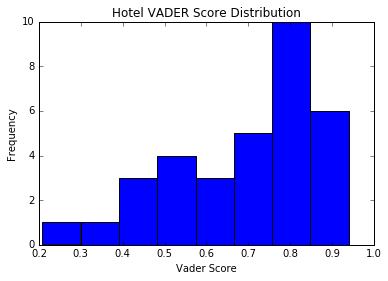

In [41]:
# Plot VADER scores on histogram
plt.hist(itemDF['avgVaderScore'].as_matrix(),bins=8)
plt.title("Hotel VADER Score Distribution")
plt.xlabel("Vader Score")
plt.ylabel("Frequency")
fig = plt.gcf()

a.) Ground truth ratings are somewhat binomially distributed while VADER scores are skewed left.  This shows that most of the reviews are positive.  This may be because people avoid hotels with lower rating, meaning there are fewer people to comment on them.

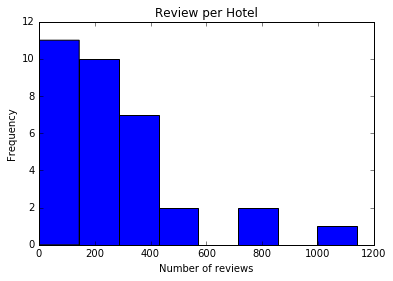

In [42]:
# Plot number of reviews per hotel on histogram
plt.hist(hotelDf['hotelName'].value_counts().as_matrix(), bins=8)
plt.title("Review per Hotel")
plt.xlabel("Number of reviews")
plt.ylabel("Frequency")
fig = plt.gcf()

b.) The histogram skews right, meaning that it is not common for a hotel to get over 600 reviews.  This is because not everyone who visits will leave a review.

#### Boxplot

In [43]:
def prepareBoxplotData(itemDf, hotelDf, scoreMethod):
    hotelNames = []
    hotelData = []
    
    # Identify sorting method to find top hotel
    scoreSortMethod = ''
    if scoreMethod =='ratingScore':
        scoreSortMethod = 'avgRatingScore'
    elif scoreMethod == 'vader':
        scoreSortMethod = 'avgVaderScore'
    
    # Get data for top 5 hotels
    for i in range(0,5):
        hotelName = itemDf.sort_values(scoreSortMethod, ascending=0).iloc[i][0]
        hotelData.append(hotelDf.loc[hotelDf['hotelName']==hotelName][scoreMethod].as_matrix())
        hotelNames.append(hotelName)
        
    return hotelNames, hotelData

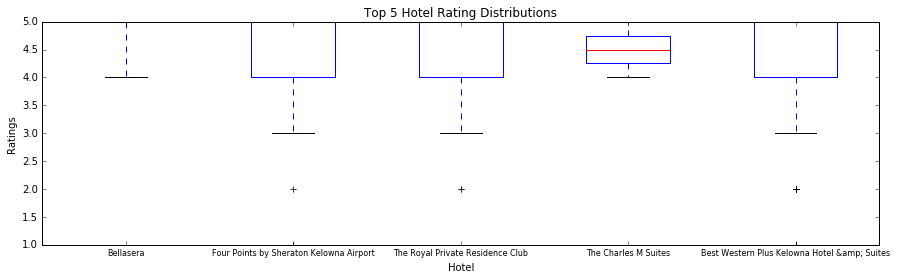

In [44]:
# Prepare Data
hotelNames, hotelRatings = prepareBoxplotData(itemDF, finalDF, 'ratingScore')

# Draw Boxplot of Top 5 Hotel Rating Distribution
fig, ax1 = plt.subplots(figsize=(15, 4))
ax1.set_title('Top 5 Hotel Rating Distributions')
ax1.set_xlabel('Hotel')
ax1.set_ylabel('Ratings')
plt.boxplot(hotelRatings)
bpLabels = plt.setp(plt.setp(ax1, xticklabels=hotelNames), fontsize=8)

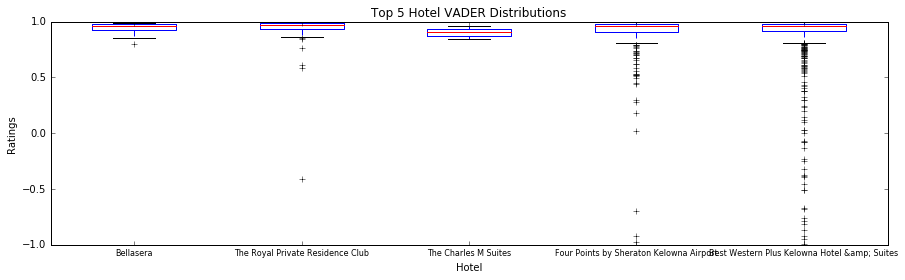

In [45]:
# Prepare Data
hotelNames, hotelRatings = prepareBoxplotData(itemDF, finalDF, 'vader')

# Draw Boxplot of Top 5 Hotel Rating Distribution
fig, ax1 = plt.subplots(figsize=(15, 4))
ax1.set_title('Top 5 Hotel VADER Distributions')
ax1.set_xlabel('Hotel')
ax1.set_ylabel('Ratings')
plt.boxplot(hotelRatings)
bpLabels = plt.setp(plt.setp(ax1, xticklabels=hotelNames), fontsize=8)

In [46]:
# Mean and varience for top 5 rated hotels
itemDF.sort_values('avgRatingScore',ascending=0).head(5)

,hotelName,avgRatingScore,varRatingScore,avgVaderScore,varVaderScore
26,Bellasera,4.916667,0.083333,0.940142,0.003491
23,Four Points by Sheraton Kelowna Airport,4.546547,0.483520,0.897856,0.045342
2,The Royal Private Residence Club,4.527273,0.661279,0.916413,0.039646
27,The Charles M Suites,4.500000,0.500000,0.903300,0.006227
5,Best Western Plus Kelowna Hotel &amp; Suites,4.438824,0.585770,0.882446,0.070511


c.) The box plots are more informative as it allows you to visually see the spread in the data, and see how different hotels compare to eachother.  Seeing the spread allows you to see the consistency in ratings, and if people tend to agree about how well the hotel performs.

#### Scatterplot

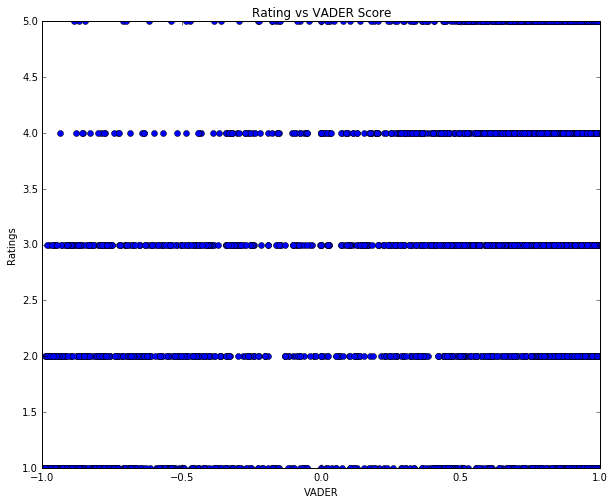

In [47]:
# Prepate data
y = finalDF['ratingScore'].as_matrix()
x = finalDF['vader'].as_matrix()

# Scatterplot of rating vs VADER score
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.set_title('Rating vs VADER Score')
ax1.set_xlabel('VADER')
ax1.set_ylabel('Ratings')
sp = plt.plot(x, y,"o")

a.) The graph shows that lower VADER scored tend to occur in lower ratings, while higher VADER scored occur alongside higher ratings.  This illustrates that VADER scores do a decent job in capturing human sentiment in reviews, which translates to a close prediction on the actual rating given.

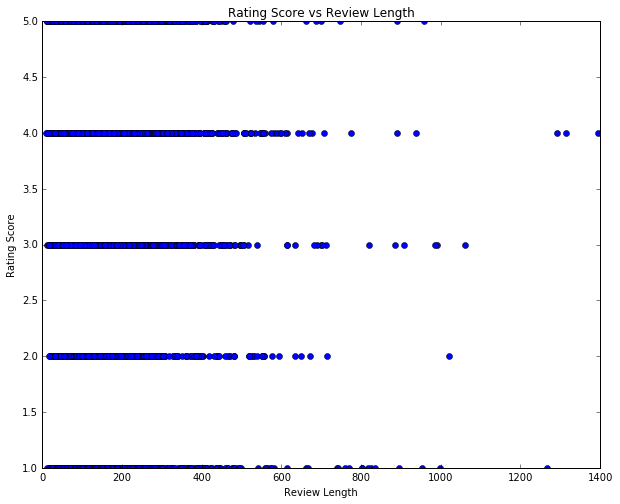

In [48]:
# Get Rating values
y = finalDF['ratingScore'].as_matrix()
# Get word count
x = [len(re.findall(r'\w+', review)) for review in finalDF['reviewCol'].as_matrix()]

# Scatterplot of rating score vs rating length
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.set_title('Rating Score vs Review Length')
ax1.set_xlabel('Review Length')
ax1.set_ylabel('Rating Score')
sp = plt.plot(x, y,"o")

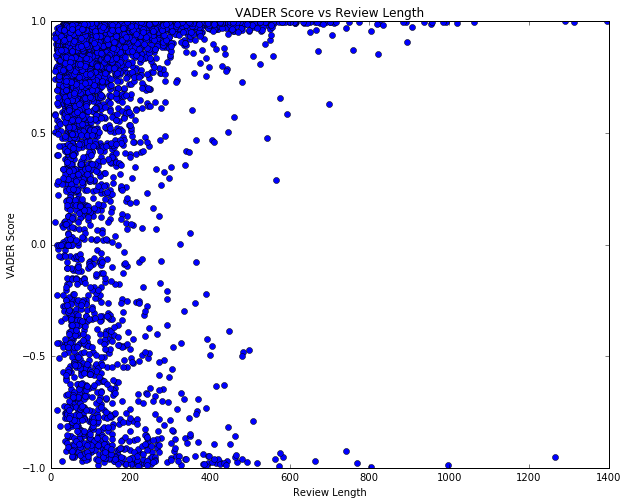

In [49]:
# Prepate data (word count from previous steup will be used)
y = finalDF['vader'].as_matrix()

# Scatterplot of VADER score vs rating length
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.set_title('VADER Score vs Review Length')
ax1.set_xlabel('Review Length')
ax1.set_ylabel('VADER Score')
sp = plt.plot(x, y,"o")

b.) The plot shows that the length of the review tends to be longer for very high, or very low VADER scores.  This shows that people tend to have more to say for a hotel which they were very happy, or dissapointed in.  Meanwhile, they dont' have much to say for a hotel that only met average expectations.

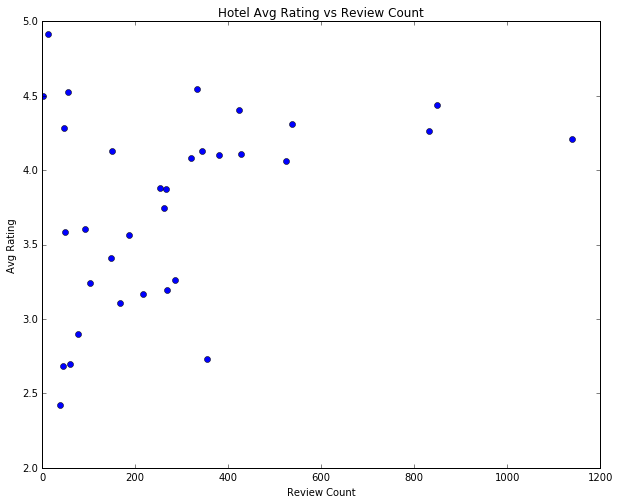

In [50]:
# Prepare dataset
hotelReviewData = finalDF.groupby(["hotelName"])['ratingScore'].agg(['mean', 'count']).as_matrix()
y = hotelReviewData[:,0]
x = hotelReviewData[:,1]

# Scatterplot of average hotel score vs rating count
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.set_title('Hotel Avg Rating vs Review Count')
ax1.set_xlabel('Review Count')
ax1.set_ylabel('Avg Rating')
sp = plt.plot(x, y,"o")

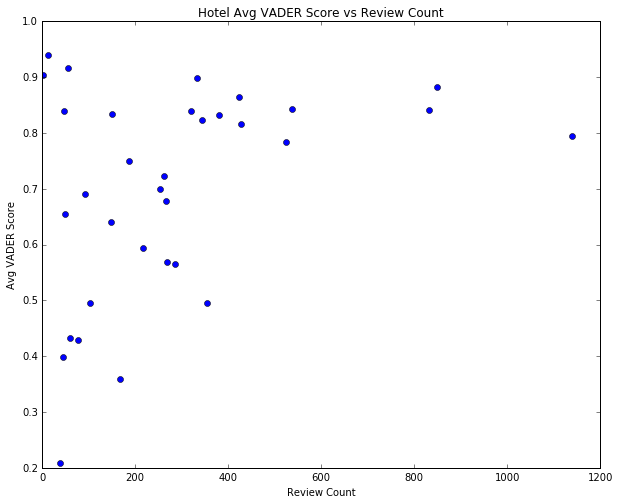

In [51]:
# Prepare dataset
hotelReviewData = finalDF.groupby(["hotelName"])['vader'].agg(['mean', 'count']).as_matrix()
y = hotelReviewData[:,0]
x = hotelReviewData[:,1]

# Scatterplot of average hotel score vs rating count
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.set_title('Hotel Avg VADER Score vs Review Count')
ax1.set_xlabel('Review Count')
ax1.set_ylabel('Avg VADER Score')
sp = plt.plot(x, y,"o")

c.) There appears to be significantly more reviews for hotels with 4-4.5 star ratings, or 0.8-0.9 VADER scores.  This is likely because that these hotels see the most clients, and therefore the most reviews.  It's highly enough rated that people will consider it, but also low enough that it is not too expensive.

## Bonus - Analysis of All Hotels Using Only Noun Phrases

Analysis only for 'all hotels' datasets as topK in original analysis is primarily single term tokens.  Top/Bottom hotel analysis appear to have more noun phrases appear as tokens.

In [52]:
# Get top K noun phrases (only) from reviews
topKnp = countWords(hotelDf['reviewColumn'].as_matrix(), onlyNp = True).most_common(k)

# Create final dataframe where ter
npDF = prepareFinalDataframe(hotelDf, topKnp)
npDF

,hotelName,ratingScore,groundTruth,reviewCol,vader,tips,night,pool,breakfast,front desk,...,balconies,good breakfast,server,view see,owner,queen bed,mini fridge,swimming pool,date,none
0,Hotel Zed Kelowna,5,positive,What a great place to stay!!! Right across fro...,0.9466,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hotel Zed Kelowna,5,positive,We found this new retro themed motel in downto...,0.8074,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hotel Zed Kelowna,5,positive,I think we were one of the very first people t...,0.9858,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,Hotel Zed Kelowna,5,positive,I stayed at the hotel with my wife and two chi...,0.9041,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hotel Zed Kelowna,3,negative,First the good. The staff are very good and at...,0.8555,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Hotel Zed Kelowna,5,positive,booked this through expedia. room for a few ni...,0.9928,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Hotel Zed Kelowna,5,positive,We stayed for one night in order to fit in som...,0.9805,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Hotel Zed Kelowna,5,positive,Mandy Farmer throws some serious Accent Inn at...,0.7603,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Hotel Zed Kelowna,4,positive,My husband and I stayed at this hotel when we ...,0.9917,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Hotel Zed Kelowna,4,positive,The hotel was clean and offered some unique ex...,0.9402,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Noun Phrase Frequency Analysis

In [53]:
# Compare top 50 words for positive reviews, and VADER scores above threshold
compareWordLists(countWords(npDF.loc[npDF['groundTruth']=='positive']['reviewCol'].as_matrix(), onlyNp = True).most_common(50),
                 countWords(npDF.loc[npDF['vader']>vaderPosThreshold]['reviewCol'].as_matrix(), onlyNp = True).most_common(50))

,Word (Ground Truth),Word Count,,Word (VADER),Word Count
0,tips,1660,,tips,2029
1,pool,1147,,night,1646
2,night,1111,,pool,1438
3,breakfast,1045,,breakfast,1320
4,location,845,,location,1052
5,restaurant,710,,front desk,982
6,service,689,,place,949
7,time,659,,time,898
8,front desk,657,,restaurant,865
9,nights,656,,nights,834


In [54]:
# Compare top 50 words for negative reviews, and VADER scores below threshold
compareWordLists(countWords(npDF.loc[npDF['groundTruth']=='negative']['reviewCol'].as_matrix(), onlyNp = True).most_common(50),
                 countWords(npDF.loc[npDF['vader']<vaderNegThreshold]['reviewCol'].as_matrix(), onlyNp = True).most_common(50))

,Word (Ground Truth),Word Count,,Word (VADER),Word Count
0,night,845,,night,243
1,tips,552,,place,196
2,front desk,528,,front desk,169
3,place,527,,tips,131
4,pool,414,,time,110
5,breakfast,399,,bed,103
6,time,378,,pool,94
7,bed,364,,breakfast,92
8,people,328,,people,89
9,nights,291,,nights,87


Ground truth and VADER scores give similar word lists in both positive and negative review cases.  Similar to the original analysis, single word nouns appear to dominate the list.

### Mutual Information

In [55]:
# Get top 50 words based on MI score using ground truth and VADER scores for all hotel
miAnalysis(npDF, topKnp)

,Word (Ground Truth),MI Score,,Word (VADER),MI Score
0,great,0.017308,,great,0.017913
1,excellent,0.012429,,friendly,0.012972
2,comfortable,0.012368,,comfortable,0.010998
3,night,0.011842,,clean,0.009847
4,get,0.010614,,helpful,0.009254
5,carpet,0.008811,,excellent,0.008905
6,nothing,0.008787,,well,0.005195
7,friendly,0.008487,,manager,0.004862
8,door,0.007753,,nice,0.004622
9,sleep,0.007633,,wonderful,0.004523


Phrases similar between ground truth and VADER lists.  Again, single word noun phrases appear to dominate the top 50 lists.

### PMI

In [56]:
# Get top 50 words based on PMI score using ground truth for all hotels
pmiAnalysis(npDF, topKnp, 'ratingScore')

,Word,pmiPos0,,Word,pmiPos1,,Word,pmiNeg0,,Word,pmiNeg1
0,would,0.019839,,pleasure,0.120160,,great,0.090239,,credit card,0.519227
1,night,0.018381,,great service,0.115706,,comfortable,0.058861,,garbage,0.515226
2,get,0.017207,,top notch,0.104575,,friendly,0.055818,,smell,0.510061
3,one,0.013591,,questions,0.098971,,clean,0.045611,,sheets,0.488581
4,place,0.010292,,perfect,0.096817,,excellent,0.037357,,carpet,0.478876
5,front desk,0.009534,,comfortable beds,0.095693,,helpful,0.035310,,sort,0.448961
6,first,0.009235,,mountains,0.091610,,well,0.029413,,customers,0.445798
7,bed,0.007977,,waterslide,0.090226,,quiet,0.022089,,hair,0.441637
8,people,0.007783,,excellent,0.089463,,perfect,0.017250,,toilet,0.424299
9,back,0.007699,,full kitchen,0.086736,,wonderful,0.016159,,walls,0.420359


In [57]:
# Get top 50 words based on PMI score using ground truth for all hotels
pmiAnalysis(npDF, topKnp, 'vader')

,Word,pmiPos0,,Word,pmiPos1,,Word,pmiNeg0,,Word,pmiNeg1
0,night,0.004851,,advantage,0.047452,,great,0.141872,,credit card,0.684108
1,get,0.004844,,nice touch,0.047452,,clean,0.120220,,situation,0.667232
2,place,0.004036,,variety,0.047452,,friendly,0.103796,,garbage,0.652509
3,would,0.004026,,great time,0.047452,,comfortable,0.087740,,smell,0.625525
4,front desk,0.003141,,wonderful,0.043327,,good,0.077614,,dollars,0.617746
5,first,0.002895,,plenty,0.043296,,nice,0.065695,,hair,0.613000
6,one,0.002723,,pleasure,0.043087,,helpful,0.063823,,sheets,0.601952
7,manager,0.002632,,bonus,0.042997,,well,0.059957,,manager,0.592028
8,check,0.002434,,comfortable beds,0.042856,,excellent,0.050182,,customers,0.581445
9,back,0.002397,,water slide,0.042599,,quiet,0.035262,,pictures,0.578722


In both ground truth and VADER PMI analysis, multi-word noun phrases make up a significant portion of the list in the postive review list (pmiPos1).